# Assignment 2
## Question 1: Siamese networks & one-shot learning (7pt)
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much fewer examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

In [0]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, concatenate
from keras.regularizers import l2
from keras.utils import to_categorical
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import shuffle
from itertools import permutations
import random 
from keras.datasets import cifar100
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


### Load the CIFAR-100 data and create training and test set


In [0]:
# Extract from Cifar-100 train and test
(x_cifar_train, y_cifar_train),(x_cifar_test,y_cifar_test) = cifar100.load_data(label_mode='fine')

print('x_cifar_train shape: ', x_cifar_train.shape)
print('y_cifar_train shape: ', y_cifar_train.shape)

# We retrieve the ordered indexes to create our train set with the first 80 classes and test set with the last 20 classes
ordered_indexes = np.argsort(y_cifar_train.flatten())
train_indexes = ordered_indexes[:int(0.8*len(ordered_indexes))]
test_indexes = ordered_indexes[int(0.8*len(ordered_indexes)):]

# x_train, x_test, y_train, y_test
x_train = x_cifar_train[train_indexes]
x_test = x_cifar_train[test_indexes]
y_train = y_cifar_train[train_indexes]
y_test = y_cifar_train[test_indexes]
print('Class ranges of training: %d to %d' % (int(y_train[0]), int(y_train[-1])))
print('Class ranges of testing: %d to %d' % (int(y_test[0]), int(y_test[-1])))

# Reshape as (n_class, n_example, width, height, depth)
x_train = np.reshape(x_train, (80,-1,32,32,3))
y_train = np.reshape(y_train, (80,-1,1))
x_test = np.reshape(x_test, (20,-1,32,32,3))
y_test = np.reshape(y_test, (20,-1,1))

print('\nx_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

169009152/169001437 [==============================] - 36s 0us/step
x_cifar_train shape:  (50000, 32, 32, 3)
y_cifar_train shape:  (50000, 1)
Class ranges of training: 0 to 79
Class ranges of testing: 80 to 99

x_train shape:  (80, 500, 32, 32, 3)
x_test shape:  (20, 500, 32, 32, 3)
y_train shape:  (80, 500, 1)
y_test shape:  (20, 500, 1)


### Create batch of pair images and target (balanced dataset)

In [0]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, d)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, d)
        idx_2 = np.random.randint(0, n_examples)
        # Last part of Batch array: pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        # First part of Batch array
        else:
            #add a random number to the category modulo n_classes to ensure 2nd image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, d)
    return pairs, targets

### Siamese network

In [0]:
input_shape = (32, 32, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64, (5,5), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))

convnet.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))

convnet.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
#convnet.add(MaxPooling2D())
#convnet.add(BatchNormalization())
#convnet.add(Dropout(0.25))

#convnet.add(Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
#convnet.add(BatchNormalization())
#convnet.add(Dropout(0.25))
convnet.add(Dense(1152, activation="sigmoid", kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)


siamese_net.compile(loss="binary_crossentropy", optimizer="adam")

siamese_net.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 128)       131200    
_________________________________________________________________
max_pooling2d_2 (MaxP

### Batch generator and Train function


In [0]:
def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=100, epochs=1, verbose=1):
    model.fit_generator(batch_generator(batch_size, x_train), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=verbose)

### One-shot functions


In [0]:
# N number of 20-oneshot tasks, k number of random tasks 250

def make_oneshot_task(N, X, Y):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    """ Just the first index 0 will have the true (both images coming from the same class)!! """
    n_classes, n_examples, w, h, d = X.shape
    
    # choose 20-random indexes from the 500 examples
    indices = np.random.randint(0, n_examples, size=(N,))
    
    # choose 20-random - since replace is False the index 0 will contain the True Unique category
    categories = np.random.choice(range(n_classes), size=(N,), replace=False)
    
    # we choose the category of the first index as the true one
    true_category = categories[0]
    
    # choose 2 random indexes for 2 examples
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    
    # test_image.shape = (20, 32, 32, 3) This is a set of 20 images of the test_image
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, d)
    
    # support set.shape = (20,32,32,3) This is a set of 20 images of random categories.
    support_set = X[categories, indices, :, :]
    
    # modify the first element of support set with ex2
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, d)
    
    # all targets are fitted with 0 (since is randomized), just the first example is true 
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    
    # shuffled pair where just one pair of images have target 1 (belonging to same class)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, Y, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    # number of correct tasks
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        # inputs is the pair of images
        inputs, targets = make_oneshot_task(N, X, Y)
        
        # in probs we store the predictions 
        probs = model.predict(inputs)
        
        # retrieve the index where is the maximum probability and compare it with the index of targets
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
          
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning during this loop".format(percent_correct, N))
    return percent_correct

In [0]:
# Train and Test the architecture
loops = 10
best_acc = 0
epochs = 1
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(siamese_net, x_train, epochs=epochs)
    test_acc = test_oneshot(siamese_net, x_test, y_test)
    if test_acc >= best_acc:
        print("New best one-shot accuracy of {}%, saving model ...".format(test_acc))
        siamese_net.save("siamese_cifar100.h5")
        best_acc = test_acc
        
print('\nBest accuracy obtained during whole training {}%.'.format(best_acc))

=== Training loop 1 ===
Epoch 1/1
100/100 [==============================] - 2s 18ms/step - loss: 0.6300
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.6% accuracy for 20-way one-shot learning during this loop
New best one-shot accuracy of 13.6%, saving model ...
=== Training loop 2 ===
Epoch 1/1
100/100 [==============================] - 2s 17ms/step - loss: 0.6338
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 18.4% accuracy for 20-way one-shot learning during this loop
New best one-shot accuracy of 18.4%, saving model ...
=== Training loop 3 ===
Epoch 1/1
100/100 [==============================] - 2s 17ms/step - loss: 0.6358
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 18.0% accuracy for 20-way one-shot learning during this loop
=== Training loop 4 ===
Epoch 1/1
100/100 [==============================] - 2s 17ms/step - loss: 0.6402
Evaluating model on 250 random 20-way

***

**b)** Compare the performance of your Siamese network for Cifar-100 to the Siamese network from Practical 4 for Omniglot. Name three fundamental differences between the Cifar-100 and Omniglot datasets. How do these differences influence the difference in one-shot accuracy?

**Answer:**


Performance comparison:

* Siamese network for Omniglot: 42.4% one-shot learning accuracy. The loss is in a range of 1 to 4.
* Siamese network for Cifar-100: 21.2% one-shot learning accuracy. The loss is  much lesser than on omniglot.


The omniglot dataset has 50 alphabets with 1623 handwritten characters. Each of the characters has 20 different samples. The CIFAR 100 dataset has 100 classes with 20 super classes and 5 sub classes per super class. Per superclass, there are 600 images.
The fundamental differences between the 2 datasets could be:


1.   CIFAR images are really small with 32*32*1 dimensions while the omniglot images are bigger with 105*105*1 dimensions. Greyscale images as omniglot with bigger dimensions are better to train a model than RGB images with smaller dimensions, which make them ambiguous.
2.   Some CIFAR images do not represent the subject fully, sometimes half of the subject is present in the image, while omniglot images are clear and big. As per models implemented by different authors, even human identification system could not reach an accuracy og 100% because some of the images are identified based on the context in the picture rather thean the whole subject present. Identifying the actual image by understanding the context is not a part of the model trained.

The above 2 factors, along with very less samples belonging to 100 finer classes contribute towards low accuracy for CIFAR 100 dataset.






***

### Task 1.2: One-shot learning with neural codes
**a)**
* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

In [0]:
keras.backend.clear_session()

In [0]:
# CNN architecture

n_classes = 100
input_shape = (32,32,3)
input_image = Input(input_shape)

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(4, 4), activation='sigmoid', input_shape=input_shape))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Conv2D(64, kernel_size=(3, 3), activation='sigmoid'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Conv2D(128, kernel_size=(2, 2), activation='sigmoid'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Flatten())
cnn.add(Dense(5000, activation='sigmoid'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(n_classes, activation='softmax'))

cnn.summary()

# encode each of the two inputs into a vector with the convnet
encoded_image = cnn(input_image)

cnn.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 29, 29, 32)        1568      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 6, 6, 64)          256       
__________

In [0]:
# Reshaping x_train, x_test, y_train, y_test

x_train_reshaped = x_train.reshape(40000,32,32,3)
y_train_reshaped = y_train.reshape(40000,1)
y_train_reshaped = to_categorical(y_train_reshaped, 100)

x_test_reshaped = x_test.reshape(10000,32,32,3)
y_test_reshaped = y_test.reshape(10000,1)
y_test_reshaped = to_categorical(y_test_reshaped, 100)

x_train_reshaped = x_train_reshaped.astype('float32')
x_train_reshaped /= 255

x_test_reshaped = x_test_reshaped.astype('float32')
x_test_reshaped /= 255


print('X train reshaped shape: ', x_train_reshaped.shape)
print('Y train reshaped shape: ',y_train_reshaped.shape)
print('X test reshaped shape: ',x_test_reshaped.shape)
print('Y test reshaped shape: ',y_test_reshaped.shape)

X train reshaped shape:  (40000, 32, 32, 3)
Y train reshaped shape:  (40000, 100)
X test reshaped shape:  (10000, 32, 32, 3)
Y test reshaped shape:  (10000, 100)


In [0]:
history = cnn.fit(x=x_train_reshaped, y=y_train_reshaped, batch_size=100, epochs=30, validation_split=0.1, callbacks=[EarlyStopping(monitor='loss', patience=1)])


Train on 36000 samples, validate on 4000 samples
Epoch 1/30
36000/36000 [==============================] - 6s 163us/step - loss: 5.5638 - acc: 0.0829 - val_loss: 10.6586 - val_acc: 0.0000e+00
Epoch 2/30
36000/36000 [==============================] - 4s 123us/step - loss: 4.5590 - acc: 0.1212 - val_loss: 12.1193 - val_acc: 0.0000e+00
Epoch 3/30
36000/36000 [==============================] - 4s 122us/step - loss: 4.1981 - acc: 0.1421 - val_loss: 12.6935 - val_acc: 0.0000e+00
Epoch 4/30
36000/36000 [==============================] - 4s 123us/step - loss: 3.9392 - acc: 0.1630 - val_loss: 12.7349 - val_acc: 0.0000e+00
Epoch 5/30
36000/36000 [==============================] - 5s 126us/step - loss: 3.6850 - acc: 0.1886 - val_loss: 12.9947 - val_acc: 0.0000e+00
Epoch 6/30
36000/36000 [==============================] - 4s 122us/step - loss: 3.5125 - acc: 0.2060 - val_loss: 12.5918 - val_acc: 0.0000e+00
Epoch 7/30
36000/36000 [==============================] - 5s 128us/step - loss: 3.3459 - acc:

In [0]:
# Loss and Test accuracy
loss, accuracy = cnn.evaluate(x_test_reshaped, y_test_reshaped, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 14.752160887145996
Test accuracy: 0.0


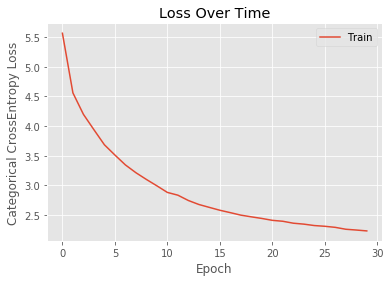

In [0]:
## Printing the Loss
%matplotlib inline
plt.plot(history.history['loss'])

plt.xlabel('Epoch')
plt.ylabel('Categorical CrossEntropy Loss')
plt.title('Loss Over Time')
plt.legend(['Train'])

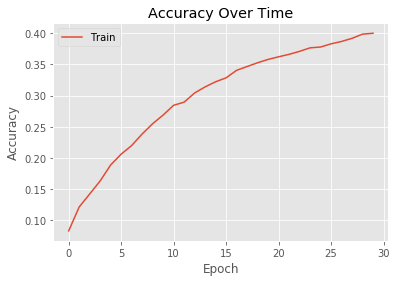

In [0]:
# Printing the Accuracy
plt.plot(history.history['acc'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend(['Train'])

## Neural codes


We ran several experiments extracting the encoding from different hidden layers and below it can be observed the 20 task one-shot accuracy reached.

* Accuracy 9.2% with Layer 5
* Accuracy 6.8% with Layer 6
* Accuracy 7.2% with Layer 7
* Accuracy 7.2% with Layer 8
* Accuracy 8.8% with Layer 9
* Accuracy 8% with Layer 10
* Accuracy 4.4% with Layer 11
* Accuracy 7.6% with Layer 12
* Accuracy 6% / 6.8%  with Layer 13
* Accuracy 9.2% / 6.4% with Layer 14
* Accuracy 6.8% / 7.6%  with Layer 15



In [0]:
# L is the layer where we will extract the encoded state
N = 20;  L = 14

outputs = [layer.output for layer in cnn.layers]  
print('Amount of stacked layers of the CNN: ', len(outputs))

encoded_state = K.function(
[cnn.layers[0].input],  # we will feed the function with the input of the first layer
[cnn.layers[L].output,] # we want to get the output of the second layer
)

Amount of stacked layers of the CNN:  17


In [0]:
def test_oneshot_cnn(X, Y, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    
    # number of correct tasks
    #print('Number of Layers to extract the encoding: %d \n\n' % L)
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    
    for i in range(k):
        # inputs is the pair of images
        inputs, targets = make_oneshot_task(N, X, Y)
        
        # test_image we just take one since the rest of the array is duplicated => shape is (1,32,32,3)
        test_image = inputs[0][0].reshape(1, 32,32,3)
        support_set = inputs[1]
        
        # we initialize min_distance variable
        min_distance = 1000000
        distance_list = []
        
        # for loop over support_set array
        for i in range(0, support_set.shape[0]):
            support_image = support_set[i].reshape(1,32,32,3)
            target = targets[i].reshape(1)

            # extract neural code from layer L
            neural_code_test_image = np.asarray(encoded_state([test_image]))
            neural_code_support_image = np.asarray(encoded_state([support_image]))

            # Compute the L2 distance
            distance = np.linalg.norm(neural_code_test_image - neural_code_support_image)
            distance_list.append(distance)

            # update the min_distance
            if(distance < min_distance):
                min_distance = distance

        # compare if the index where the distance is minimum corresponds to the index where the target is 1
        if np.argmax(distance) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning during this loop".format(percent_correct, N))
    return percent_correct


# Train and Test the architecture
loops = 10
best_acc = 0
epochs = 1
for i in range(loops):
    print("=== Loop {} ===".format(i+1))
    # Call test_oneshot_cnn functions
    test_acc = test_oneshot_cnn(x_test, y_test)
    if test_acc >= best_acc:
        print("New best one-shot accuracy of {}%  ...".format(test_acc))
        best_acc = test_acc
        
print('\nBest accuracy obtained during whole training {}%.'.format(best_acc))

=== Loop 1 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning during this loop
New best one-shot accuracy of 8.0%  ...
=== Loop 2 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 1.6% accuracy for 20-way one-shot learning during this loop
=== Loop 3 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 4.8% accuracy for 20-way one-shot learning during this loop
=== Loop 4 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 5.6% accuracy for 20-way one-shot learning during this loop
=== Loop 5 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 5.6% accuracy for 20-way one-shot learning during this loop
=== Loop 6 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 5.2% accuracy for 20-way one-shot learning during this loop
=== Lo

***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:**

* For building the CNN architecture, we tried to use the one provided
in CIFAR-10, however we didn't succeed in having a good result with it.
This is mainly because of the less amount of examples per class. While
in CIFAR-10 we just have 10 classes and 5000 samples for training and
1000 samples for testing per class, in CIFAR-100 we have 100 classes and
just 500 samples for training and 100 for testing.

* The accuracy of the classifier reaches 40% but the validation accuracy is always 0%.
If we decrease the validation split (0.005) we have validation accuracy above 0%, however
the behaviour of this loss looks random. That's why when we compute the test accuracy
we have 0%.

* At one point, when adding more layers, we could contain the validation loss and reaching 40% for training accuracy, but still got 0% in validation accuracy.

* For the one-shot learning on neural codes, we run several experiments extracting
 the encoding in different hidden layers and on average we obtained an accuracy of maximum
10%. The neural codes are obtained from hidden layer L and then computed the distance 
between the test image and all the images of the support set. We consider that the shot is
correct if the index where the minimum distance was found is the same as the index where the target
had 1.

***
## Question 2: Triplet networks & one-shot learning (10pt)

### Task 2.1: Train a triplet network
**a)**
* Train a triplet network on the first 80 classes of (the training set of) Cifar-100.
 
* Make sure the network achieves a smaller loss than the margin and the network does not collapse all representations to zero vectors. *HINT: If you experience problems to achieve this goal, it might be helpful to tinker the learning rate.*

* You are provided with a working example of triplet loss implementation for Keras below. You may directly use it.

You may ignore the test set of Cifar-100 for this question as well. It suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

```python
# Notice that ground truth variable is not used for loss calculation. It is used as a function argument to by-pass some Keras functionality. This is because the network structure already implies the ground truth for the anchor image with the "positive" image.
import tensorflow as tf
def triplet_loss(ground_truth, network_output):

    anchor, positive, negative = tf.split(network_output, num_or_size_splits=3, axis=1)        
    
    for embedding in [anchor, positive, negative]:
        embedding = tf.math.l2_normalize(embedding)

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)
    
    margin = # define your margin
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), margin)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), axis=0)

    return loss
```


In [0]:
keras.backend.clear_session()

In [0]:
# triplet loss function

def triplet_loss(ground_truth, network_output):

#     anchor, positive, negative = tf.split(network_output, num_or_size_splits=3, axis=1)        

#     for embedding in [anchor, positive, negative]:
#         embedding = tf.math.l2_normalize(embedding)
        
    anchor, positive, negative = (tf.math.l2_normalize(x) for x in tf.split(network_output, num_or_size_splits=3, axis=1))

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)

    margin = 0.4 # define your margin
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), margin)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), axis=0)

    return loss

In [0]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [0]:
# create tripet model
input_shape = (32, 32, 3)

anchor_input = Input(input_shape)
positive_input = Input(input_shape)
negative_input = Input(input_shape)


tNet = Sequential()

tNet.add(Conv2D(128,(7,7), padding='same', input_shape = input_shape, activation='relu', name='conv1'))
tNet.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))

tNet.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
tNet.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))

tNet.add(Flatten(name='flatten'))
tNet.add(Dense(4,name='embeddings'))

tNet.summary()


# encode each of the two inputs into a vector with the convnet
encoded_anchor = tNet(anchor_input)
encoded_positive = tNet(positive_input)
encoded_negative = tNet(negative_input)

merged_encoding = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')


triplet_net = Sequential()
triplet_net = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_encoding)

triplet_net.compile(loss=triplet_loss, optimizer=adam_optim)

triplet_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 128)       18944     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 256)       819456    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
embeddings (Dense)           (None, 4)                 65540     
Total params: 903,940
Trainable params: 903,940
Non-trainable params: 0
_________________________________________________________________
____

In [0]:

# Generate the triplets
def Generate_Triplets(X, Y, k = 20):

  triplet_pairs = []
  pairs = tuple([X, Y])
  y_sorted = np.unique(Y)

  for category in y_sorted:
      same_class_indx = np.where(pairs[1] == category)[0]
      diff_class_indx = np.where(pairs[1] != category)[0]

      A_P_pairs = random.sample(list(permutations(same_class_indx, 2)), k = k) #Generating Anchor-Positive pairs
      Neg_idx = random.sample(list(diff_class_indx), k = k)


      for ap in A_P_pairs[:int(len(A_P_pairs))]:
          Anchor = X[0][ap[0]]
          Positive = X[0][ap[1]]
          for n in Neg_idx:
              Negative = X[0][n]
              triplet_pairs.append([Anchor,Positive,Negative]) 

  return np.array(triplet_pairs)

In [0]:
# triplet Train and Test
triplet_train_pairs = Generate_Triplets(x_train, y_train, k=20)
triplet_test_pairs = Generate_Triplets(x_test, y_test, k=20)

Anchor = triplet_train_pairs[:,0,:].reshape(-1,32,32,3)
Positive = triplet_train_pairs[:,1,:].reshape(-1,32,32,3)
Negative = triplet_train_pairs[:,2,:].reshape(-1,32,32,3)

Anchor_test = triplet_test_pairs[:,0,:].reshape(-1,32,32,3)
Positive_test = triplet_test_pairs[:,1,:].reshape(-1,32,32,3)
Negative_test = triplet_test_pairs[:,2,:].reshape(-1,32,32,3)

Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

triplet_net.fit([Anchor,Positive,Negative],y=Y_dummy, validation_split=0.2, batch_size=100, epochs=30, callbacks=[EarlyStopping(monitor='loss', patience=1)])


Train on 25600 samples, validate on 6400 samples
Epoch 1/30
25600/25600 [==============================] - 15s 591us/step - loss: 0.3799 - val_loss: 0.3793
Epoch 2/30
25600/25600 [==============================] - 15s 583us/step - loss: 0.3783 - val_loss: 0.3794
Epoch 3/30
25600/25600 [==============================] - 15s 586us/step - loss: 0.3765 - val_loss: 0.3791
Epoch 4/30
25600/25600 [==============================] - 15s 572us/step - loss: 0.3754 - val_loss: 0.3782
Epoch 5/30
25600/25600 [==============================] - 15s 568us/step - loss: 0.3746 - val_loss: 0.3792
Epoch 6/30
25600/25600 [==============================] - 15s 566us/step - loss: 0.3740 - val_loss: 0.3787
Epoch 7/30
25600/25600 [==============================] - 15s 574us/step - loss: 0.3736 - val_loss: 0.3799
Epoch 8/30
25600/25600 [==============================] - 15s 575us/step - loss: 0.3733 - val_loss: 0.3800
Epoch 9/30
25600/25600 [==============================] - 15s 577us/step - loss: 0.3732 - val_l

***

### Task 2.2: One-shot learning with triplet neural codes
**a)**
* Use neural codes from the triplet network with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.
* Explicitly state the accuracy.

In [0]:
def make_oneshot_task_triplet(N, X, Y):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    """ Just the first index 0 will have the true (both images coming from the same class)!! """
    n_classes, n_examples, w, h, d = X.shape
    
    # choose 21-random (1 anchor, 20 positive) indexes from the 500 examples
    indices_positive = np.random.choice(range(n_examples), size=(N + 1,), replace=False)
    
    # choose 20-random (20 negative) indexes from the 500 examples
    indices_negative = np.random.choice(range(n_examples), size=(N,), replace=False)
    
    # choose 21-random  (1 anchor/positive and 20 negative) since replace is False the index 0 will contain the True Unique category
    categories = np.random.choice(range(n_classes), size=(N+1,), replace=False)
    #print(categories)
    
    # we choose the category of the first index as the true one
    true_category = categories[0]
    
    # choose 2 random indexes for 2 examples comparison?
    #ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    
    # anchor_set.shape = (20, 32, 32, 3) This is a set of 20 images of the true category???? Is repeated 20 times the same image??
    anchor_set = np.asarray([X[true_category, indices_positive[0], :, :]]*N).reshape(N, w, h, d)
    
    # positive_set
    positive_set = X[true_category, indices_positive[1:N+1], :, :]

    # negative_set
    negative_set = X[categories[1:N+1], indices_negative, :, :]
    
    anchor_set, positive_set, negative_set = shuffle(anchor_set, positive_set, negative_set)
    
    return anchor_set, positive_set, negative_set

In [0]:
# L from 7 is Flat layer!
N = 19;  L = 4

outputs = [layer.output for layer in tNet.layers]  
print('Amount of stacked layers: ', len(outputs))

encoded_state = K.function(
[tNet.layers[0].input],  # we will feed the function with the input of the first layer
[tNet.layers[L].output,] # we want to get the output of the second layer
)

Amount of stacked layers:  6


In [0]:
def test_oneshot_triplet(X, Y, N=19, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    
    # number of correct tasks
    print('Number of Layers to extract the encoding: %d \n\n' % L)
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    
    for i in range(k):
        # inputs is the pair of images
        anchor, positive, negative = make_oneshot_task_triplet(19, x_test, y_test)
        
        # test_image we just take one since the rest of the array is duplicated => shape is (1,32,32,3)
        anchor_image = anchor[0].reshape(1, 32,32,3)
        
        # we initialize min_distance variable
        min_distance = 1000000;   max_distance = 0
        positive_distance_list = []
        negative_distance_list = []
        
        # for loop over support_set array
        for i in range(0, positive.shape[0]):
            positive_image = positive[i].reshape(1,32,32,3)
            negative_image = negative[i].reshape(1,32,32,3)
            
            #print(anchor_image.shape)
            #print(positive_image.shape)
            #print(negative_image.shape)

            # extract neural code from layer L
            neural_code_anchor_image = np.asarray(encoded_state([anchor_image]))
            neural_code_positive_image = np.asarray(encoded_state([positive_image]))
            neural_code_negative_image = np.asarray(encoded_state([negative_image]))

            # Compute the L2 distance
            positive_distance = np.linalg.norm(neural_code_anchor_image - neural_code_positive_image)
            negative_distance = np.linalg.norm(neural_code_anchor_image - neural_code_negative_image)
            positive_distance_list.append(positive_distance)
            negative_distance_list.append(negative_distance)

            # update the min_distance
            if(negative_distance < min_distance):
                min_distance = negative_distance
                #print('\nFound a new min_distance: {}. Image set index: {}'.format(min_distance, i))
                
            if(positive_distance > max_distance):
                max_distance = positive_distance


        if np.argmax(negative_distance_list) == np.argmin(positive_distance_list):
            n_correct += 1
            #print('CORRECT!!!!')
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning during this loop".format(percent_correct, N))
    return percent_correct




# Train and Test the architecture!
loops = 10
best_acc = 0
epochs = 1
for i in range(loops):
    print("=== Loop {} ===".format(i+1))
    # train(siamese_net, x_train, epochs=epochs)
    test_acc = test_oneshot_triplet(x_test, y_test)
    if test_acc >= best_acc:
        print("New best one-shot accuracy of {}%  ...".format(test_acc))
        #siamese_net.save("siamese_cifar100.h5")
        best_acc = test_acc
        
print('\nBest accuracy obtained during whole training {}%.'.format(best_acc))

=== Loop 1 ===
Number of Layers to extract the encoding: 4 


Evaluating model on 250 random 19-way one-shot learning tasks ...
Got an average of 6.4% accuracy for 19-way one-shot learning during this loop
New best one-shot accuracy of 6.4%  ...
=== Loop 2 ===
Number of Layers to extract the encoding: 4 


Evaluating model on 250 random 19-way one-shot learning tasks ...
Got an average of 4.4% accuracy for 19-way one-shot learning during this loop
=== Loop 3 ===
Number of Layers to extract the encoding: 4 


Evaluating model on 250 random 19-way one-shot learning tasks ...
Got an average of 3.2% accuracy for 19-way one-shot learning during this loop
=== Loop 4 ===
Number of Layers to extract the encoding: 4 


Evaluating model on 250 random 19-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 19-way one-shot learning during this loop
New best one-shot accuracy of 8.0%  ...
=== Loop 5 ===
Number of Layers to extract the encoding: 4 


Evaluating model on 250 random 19-

***
## Question 3: Performance comparison (3pt)


**a)** What accuracy would random guessing achieve (on average) on this dataset? Motivate your answer briefly.

The average accuracy for random guessing would be 1/20 = 0.05 which is 5%



**b)** Discuss and compare the performances of networks in tasks 1.1, 1.2 and 2.2. Briefly motivate and explain which task would be expected the highest accuracy. Explain the reasons of the accuracy difference if there are any. If there is almost no difference accuracy, explain the reason for that.

* 1.1 Best accuracy obtained during whole training 21.2%. siamese for Cifar-100 250 random task on 20 pairs of images.
* 1.2 CNN test accuracy always 0, training accuracy >40%, with neural codes one shot learning 8%. 
* 2.2 Triplet network accuracy varies in different tasks with maximum reaching 8%.

Traditional Siamese network is expected to perform better than the other two it works on a distance based loss calculating model as opposed to classification models like CNN. It basically learns what makes a pair of input similar or dissimilar by focussing on the embeddings that place the two classes together, rather than trying to learn how to identify or classify a particular image. The way a siamese network works makes it robust to smaller training data because a few pairs of images are sufficient to recognize the same image in the future. The main difference is that siamese network recognizes and the CNN predicts, which is why siamese performs better for incoherent or small dataset.

***
## Question 4: Peer review (0pt)

Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others?

The assignment is hard and time consuming enough for being unable to do all of it alone. In order to understand every step properly, write code, decode the given code, without working together it is impossible. At some point we have not succeeded in getting correct results but we put a lot of effort in trying different models out.